In [63]:
import numpy as np
import cv2
import kagglehub
import json
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

path = kagglehub.dataset_download("humansintheloop/teeth-segmentation-on-dental-x-ray-images")

print("Path to dataset files:", path)

Path to dataset files: /home/mamusiaarusia/.cache/kagglehub/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images/versions/1


In [ ]:
sources = {k: Path(path) / f'Teeth Segmentation {k}' for k in ['JSON', 'PNG']}

meta = {}
for p in sources.values():
    meta.update(json.loads((p / 'meta.json').read_text()))

images = [
    Image.open(img_path) 
    for p in sources.values() 
    for img_path in (p / 'd2' / 'img').glob('*')
]

images_np = [np.array(image) for image in images]

# kszalt zdjec: 1024 x (1024 - 2041) w zaleznosci od zdjecia

In [258]:
def to_fft(img):
    # cv2 musi miec float32 na wejsciu
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    return np.fft.fftshift(dft) # 0hz (srednia) na srodek

def from_fft(dft_shifted):
    f_ishift = np.fft.ifftshift(dft_shifted) # 0hz z powrotem do rogu
    img_back = cv2.idft(f_ishift) # odwrotna transformata
    mag = cv2.magnitude(img_back[:,:,0], img_back[:,:,1]) # amplituda (modul zespolonej)
    cv2.normalize(mag, mag, 0, 255, cv2.NORM_MINMAX) # zeby nie wywalilo wartosci w kosmos
    return np.uint8(mag)

def get_bandpass_mask(image, r_min, r_max):
    rows, cols, _ = image.shape
    crow, ccol = rows // 2, cols // 2
    
    y, x = np.ogrid[:rows, :cols]
    dist = np.sqrt((x - ccol)**2 + (y - crow)**2) # pitagoras od srodka
    
    mask = np.zeros((rows, cols, 2), np.float32) # 2 kanaly bo liczby zespolone
    mask[(dist >= r_min) & (dist <= r_max)] = 1 # przepuszczamy pasmo
    return image * mask

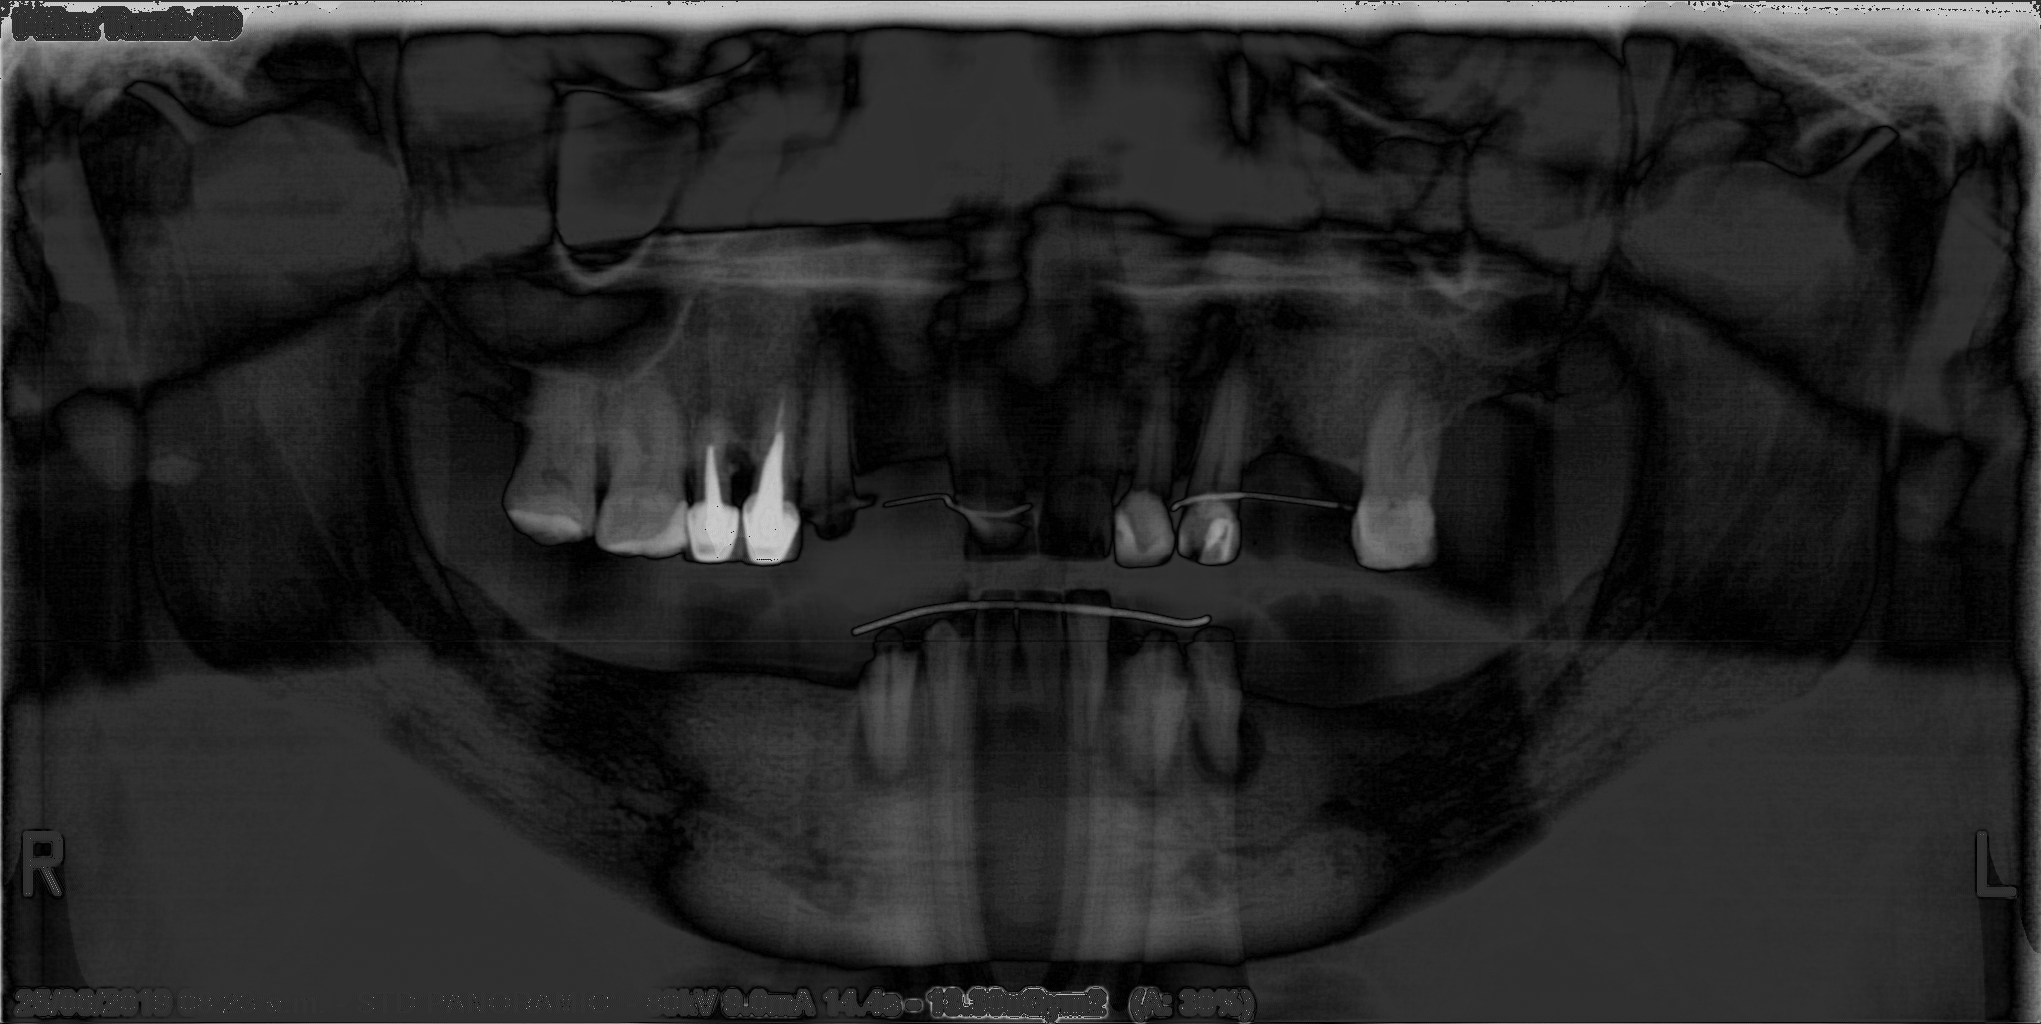

In [ ]:
fft_img = to_fft(image)
fft_img = get_bandpass_mask(fft_img, 0.1, 1000)
temp_image = from_fft(fft_img)

Image.fromarray(temp_image)

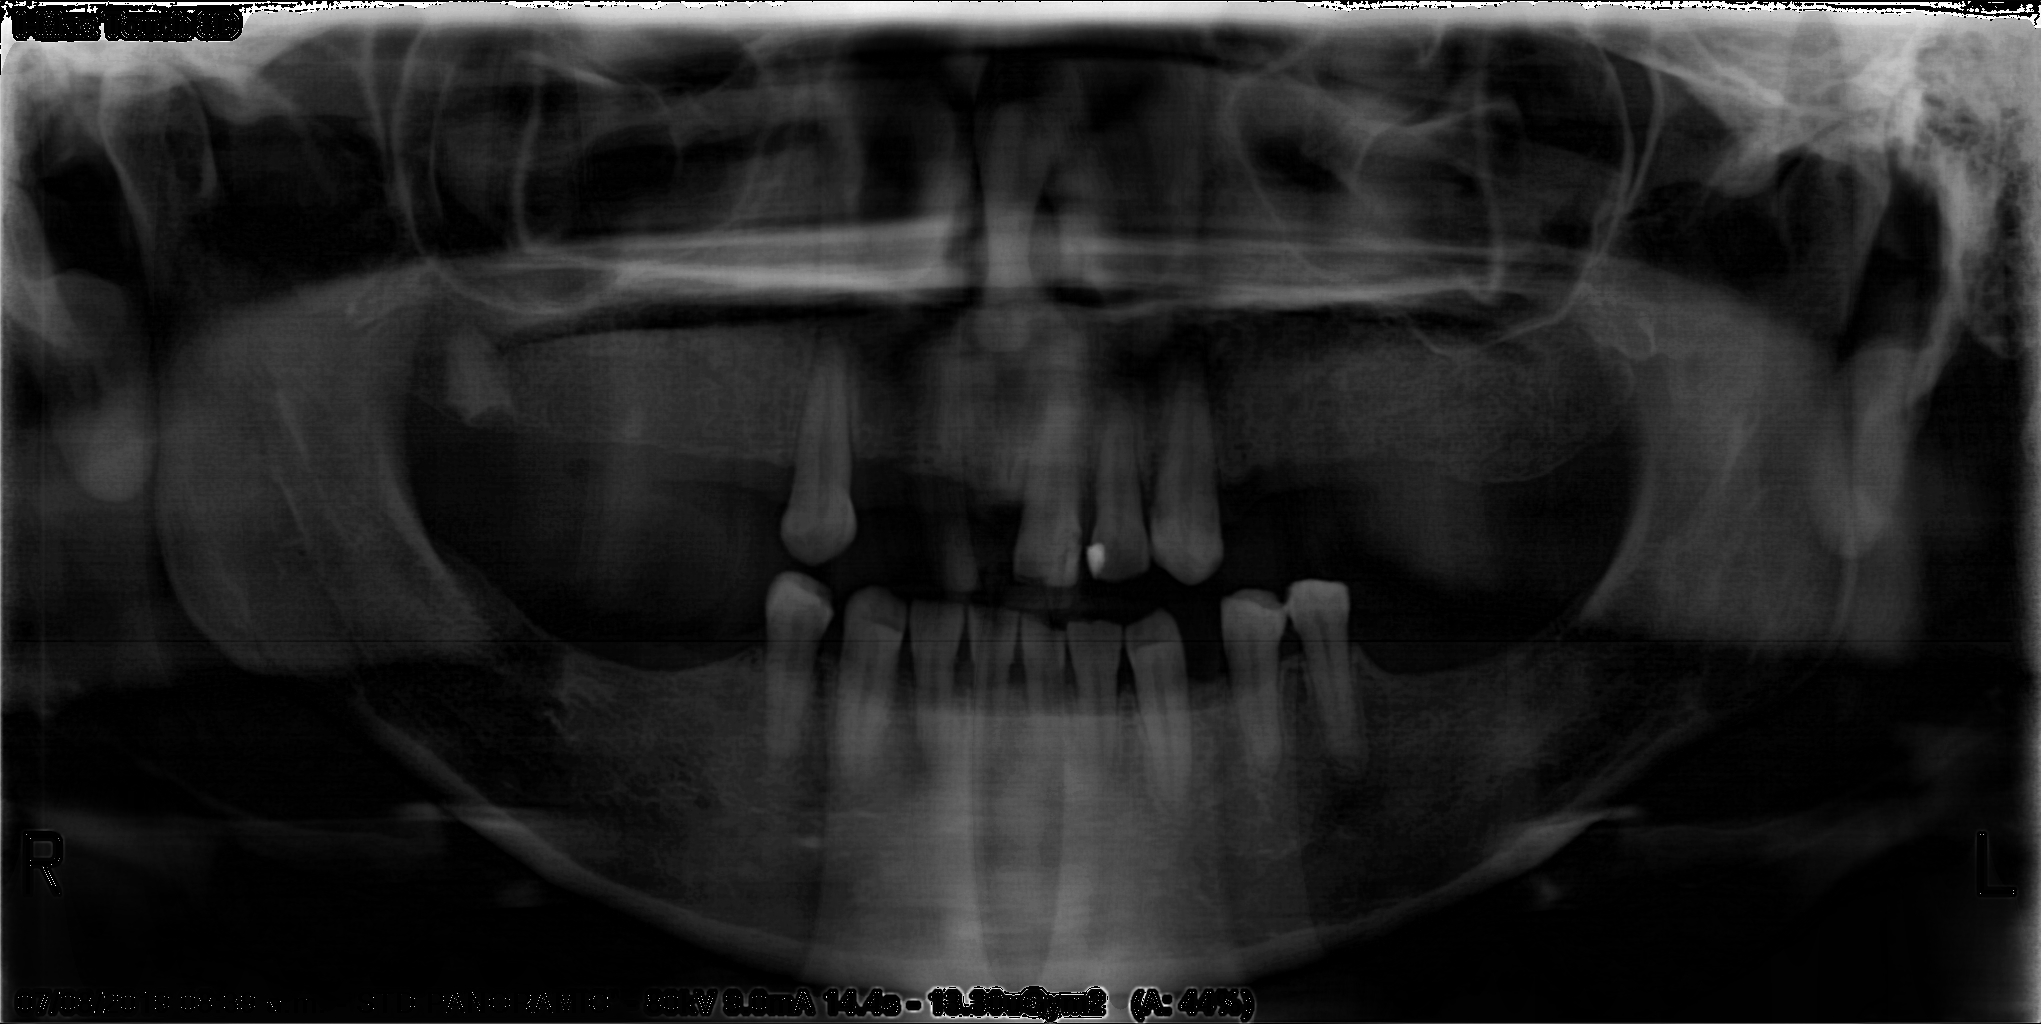

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (69, 420))

#* PLAYGROUND 
image = images_np[0]
image[image >= 250] = 0.0 # usuwanie super jasnych napisow 
image = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

# filtr gorno-przepustowy obcina czesc zuchwy, roznie on dziala zaleznie od zdjecia
# fft_img = to_fft(image)
# fft_img = get_bandpass_mask(fft_img, 0.1, 1000)
# image = from_fft(fft_img)

image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX) # nie widze roznicy
# divide = np.linspace(0, 255, num=15) # progowanie nie wiem czy pomoze nie widze roznicy - na koniec powinno byc ok
# for i in range(1, len(divide)):
#     avg = (divide[i] + divide[i-1]) // 2
#     image[(image < divide[i]) & (image > divide[i-1])] = avg

Image.fromarray(image)

In [250]:
"""
    Transformata Fouriera to nie jest dobry pomysl - wydaje sie jakby pasowal do problemu ale tak naprawde
"""

'\n    Transformata Fouriera to nie jest dobry pomysl - wydaje sie jakby pasowal do problemu ale tak naprawde\n'